In [1]:
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import rcParams
import seaborn as sns
import re

# Load data

## for barcode, feature, matrix file.

In [2]:
# barcode, feature, matrix 파일을 읽어서 AnnData 객체로 바꾼 후 adata_list에 저장.
import glob
import shutil
def read_10x_mtx_multiple(directory):
    # matrix, barcodes, features 파일 검색
    matrix_files = glob.glob(os.path.join(directory, '*matrix.mtx.gz'))
    barcode_files = glob.glob(os.path.join(directory, '*barcodes.tsv.gz'))
    feature_files = glob.glob(os.path.join(directory, '*features.tsv.gz'))
    feature_files += glob.glob(os.path.join(directory, '*genes.tsv.gz'))
    
    adata_list = []
    # print(matrix_files)
    
    for matrix_file in matrix_files:
        # 파일 이름에서 base_name (공통 이름) 추출
        base_name = os.path.basename(matrix_file).split('matrix')[0]
        
        # base_name 으로 barcodes, features (genes) 파일 찾기
        barcode_file = [bf for bf in barcode_files if base_name in bf]
        feature_file = [ff for ff in feature_files if base_name in ff]
        print(matrix_file, barcode_file, feature_file)
        
        if len(barcode_file) == 1 and len(feature_file) == 1:   # 만약 barcode, feature 파일이 하나씩 있는 경우
            matrix_dir = os.path.dirname(matrix_file)
            
            # 임시 디렉토리 생성 및 파일 복사
            temp_dir = os.path.join(directory, base_name + '_temp')
            os.makedirs(temp_dir, exist_ok=True)
            
            shutil.copy(matrix_file, os.path.join(temp_dir, 'matrix.mtx.gz'))
            shutil.copy(barcode_file[0], os.path.join(temp_dir, 'barcodes.tsv.gz'))
            
            if 'features' in feature_file[0]:   # features.tsv.gz 파일인 경우
                # shutil.copy(feature_file[0], os.path.join(temp_dir, 'features.tsv.gz'))
                features = pd.read_csv(feature_file[0], header = None, sep = '\t', compression = 'gzip')
                if features.shape[1] == 1: # gene name column만 있는 경우
                    features['gene_id'] = features[0]
                    features['feature_type'] = 'Gene Expression'
                    features = features[[0, 'gene_id', 'feature_type']]
                features.to_csv(os.path.join(temp_dir, 'features.tsv.gz'), header = False, index = False, sep = '\t', compression = 'gzip')
            else:   # genes.tsv.gz 파일인 경우 (type column이 없이 gene ID, gene name만 있는 경우)
                # genes.tsv.gz 파일을 features.tsv.gz 형식으로 변환
                genes = pd.read_csv(feature_file[0], header = None, sep = '\t', compression = 'gzip')
                genes['type'] = 'Gene Expression'
                genes.to_csv(os.path.join(temp_dir, 'features.tsv.gz'), header = False, index = False, sep = '\t', compression = 'gzip')
            
            # read data
            adata = sc.read_10x_mtx(
                path = temp_dir,
                var_names = 'gene_symbols',
                make_unique = True
            )
            adata.var_names_make_unique()   # gene 이름 중복 제거
            adata.obs['sample'] = base_name # sample 열 추가
            adata.obs['sample'] = adata.obs['sample'].apply(lambda x: re.search(r'_(.*?)_', x).group(1)) # 파일 이름에서 _와 _ 사이의 문자열 추출
            
            # 임시 디렉토리 및 파일 삭제
            shutil.rmtree(temp_dir)
            
            adata_list.append(adata)
        else:   # 파일이 없거나 여러개인 경우
            print(f"Could not find matching barcode of feature file for {base_name}")
            
    return adata_list

In [3]:
folder_path = "C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/concat/"
adata_list = read_10x_mtx_multiple(folder_path)

adata_list
# 40s for 24 samples
# 1m 39s for 104 samples

C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/concat\GSM5319503_SF10099_matrix.mtx.gz ['C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/concat\\GSM5319503_SF10099_barcodes.tsv.gz'] ['C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/concat\\GSM5319503_SF10099_features.tsv.gz']
C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/concat\GSM5319504_SF10432_matrix.mtx.gz ['C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/concat\\GSM5319504_SF10432_barcodes.tsv.gz'] ['C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/concat\\GSM5319504_SF10432_features.tsv.gz']
C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/concat\GSM5319505_SF10857_matrix.mtx.gz ['C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/concat\\GSM5319505_SF10857_barcodes.tsv.gz'] ['C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/concat\\GSM5319505_SF10857_features.tsv.gz']
C:/Users/heung/OneDriv

[AnnData object with n_obs × n_vars = 568 × 33694
     obs: 'sample'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 994 × 33694
     obs: 'sample'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 2624 × 33694
     obs: 'sample'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 4134 × 33694
     obs: 'sample'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 5783 × 33694
     obs: 'sample'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 1300 × 33694
     obs: 'sample'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 6686 × 33694
     obs: 'sample'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 3705 × 33694
     obs: 'sample'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 1332 × 33694
     obs: 'sample'
     var: 'gene_ids', 'feature_types',
 AnnData object with 

In [4]:
len(adata_list)

104

# Basic filtering

In [5]:
for adata in adata_list:
    sc.pp.filter_cells(adata, min_genes = 30)
adata_list

[AnnData object with n_obs × n_vars = 568 × 33694
     obs: 'sample', 'n_genes'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 994 × 33694
     obs: 'sample', 'n_genes'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 2624 × 33694
     obs: 'sample', 'n_genes'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 4134 × 33694
     obs: 'sample', 'n_genes'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 5783 × 33694
     obs: 'sample', 'n_genes'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 1300 × 33694
     obs: 'sample', 'n_genes'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 6686 × 33694
     obs: 'sample', 'n_genes'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 3705 × 33694
     obs: 'sample', 'n_genes'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 1332

# C10orf54와 VSIR의 count 합치기
많은 CX?\d*orf\d 유전자가 있음.

In [6]:
old_gene_name = 'C10orf54'
new_gene_name = 'VSIR'

# 'C10orf54'가 존재하고 'VSIR'이 존재하지 않을 때 gene name 변경
for adata in adata_list:
    if old_gene_name in adata.var_names and new_gene_name not in adata.var_names:
        adata.var_names = np.where(adata.var_names == old_gene_name, new_gene_name, adata.var_names)
    

# n_count_RNa, n_count_feature, pct_mt filtering

In [7]:
# list of ribosommal genes
# for mouse genes
# ribo_url = 'https://www.gsea-msigdb.org/gsea/msigdb/mouse/download_geneset.jsp?geneSetName=GOCC_RIBOSOME&fileType=gmt'
# ribo_genes = pd.read_table(ribo_url, sep = '\t', header = None).transpose().drop([0, 1])

# for human genes
ribo_url = 'http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt'
ribo_genes = pd.read_table(ribo_url, skiprows = 2, header = None)

del ribo_url

In [8]:
# Calculate QC metrics
for adata in adata_list:
    adata.var['mito'] = adata.var_names.str.startswith('MT-')   # 'mt-' for mouse, 'MT-' for human  # mitochondrial genes boolean
    adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)  # ribosomal genes boolean
    
    sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True, qc_vars=['mito', 'ribo'])    # calculate qc metrics

    # remove useless vars
    adata.obs.drop(columns=['total_counts_mito', 'total_counts_ribo'], inplace=True)
    adata.var.drop(columns=['mito', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'], inplace=True)

adata_list
del ribo_genes

In [9]:
adata_list[1].obs.head(5)

,sample,n_genes,n_genes_by_counts,total_counts,pct_counts_mito,pct_counts_ribo
AAACCCACAAGCTGCC-1,SF10432,165,165,178.0,0.000000,0.000000
AAACCCACACTAAACC-1,SF10432,107,107,112.0,0.000000,0.892857
AAACGAAAGAGCCGAT-1,SF10432,450,450,501.0,0.199601,0.000000
AAACGAATCTGACCCT-1,SF10432,176,176,206.0,0.000000,0.000000
AAACGCTAGGACTAAT-1,SF10432,127,127,136.0,0.000000,0.000000


In [ ]:
# Histogram of the cell quality
for adata in adata_list:
    fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (12, 3))
    n_bins = 50
    ax[0].hist(adata.obs.n_genes_by_counts, bins = n_bins)
    ax[0].set_title("n_genes_by_counts")
    
    ax[1].hist(adata.obs.total_counts, bins = n_bins)
    ax[1].set_title("total_counts")
    
    ax[2].hist(adata.obs.pct_counts_mito, bins = n_bins)
    ax[2].set_title("pct_counts_mito")
    
    ax[3].hist(adata.obs.pct_counts_ribo, bins = n_bins)
    ax[3].set_title("pct_counts_ribo")
    

    plt.tight_layout()
    plt.show
    del fig, ax, n_bins

In [ ]:
# Violin plot of the cell quality
for adata in adata_list:
    sc.pl.violin(
        adata,
        ['n_genes_by_counts', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo'],
        jitter = 0.4,
        multi_panel = True
    )

In [ ]:
# Scatter plot of the cell quality
rcParams['figure.figsize'] = 4, 4 # width, height

for adata in adata_list:
    sc.pl.scatter(
        adata,
        x = 'total_counts',
        y = 'n_genes_by_counts',
        color = 'pct_counts_mito',
    )

In [10]:
# Filter the data
for i in range(len(adata_list)):
    cutoff_top = np.quantile(adata_list[i].obs.n_genes_by_counts.values, .95)
    adata_list[i] = adata_list[i][adata_list[i].obs.n_genes_by_counts < cutoff_top]
    
    cutoff_top = np.quantile(adata_list[i].obs.total_counts.values, .95)
    adata_list[i] = adata_list[i][adata_list[i].obs.total_counts < cutoff_top]
    
    cutoff_top = np.quantile(adata_list[i].obs.pct_counts_mito.values, .90)
    adata_list[i] = adata_list[i][adata_list[i].obs.pct_counts_mito < cutoff_top]

adata_list
del cutoff_top, i

In [ ]:
# Histogram of the cell quality
for adata in adata_list:
    fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (12, 3))
    n_bins = 50
    ax[0].hist(adata.obs.n_genes_by_counts, bins = n_bins)
    ax[0].set_title("n_genes_by_counts")
    
    ax[1].hist(adata.obs.total_counts, bins = n_bins)
    ax[1].set_title("total_counts")
    
    ax[2].hist(adata.obs.pct_counts_mito, bins = n_bins)
    ax[2].set_title("pct_counts_mito")
    
    ax[3].hist(adata.obs.pct_counts_ribo, bins = n_bins)
    ax[3].set_title("pct_counts_ribo")
    

    plt.tight_layout()
    plt.show
    del fig, ax, n_bins

In [ ]:
# Violin plot of the cell quality
for adata in adata_list:
    sc.pl.violin(
        adata,
        ['n_genes_by_counts', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo'],
        jitter = 0.4,
        multi_panel = True
    )

In [ ]:
# Scatter plot of the cell quality
rcParams['figure.figsize'] = 4, 4 # width, height

for adata in adata_list:
    sc.pl.scatter(
        adata,
        x = 'total_counts',
        y = 'n_genes_by_counts',
        color = 'pct_counts_mito',
    )

In [11]:
# 세포가 1개 이상인 샘플만 남기기
adata_list = [adata for adata in adata_list if adata.n_obs > 0]
len(adata_list)

94

In [12]:
# 각 adata의 n_obs 값을 확인하고, 그 중 최솟값을 구함
n_obs_list = [adata.n_obs for adata in adata_list]
min_n_obs = min(n_obs_list)

print(f"The minimum n_obs in adata_list is {min_n_obs}.")

The minimum n_obs in adata_list is 153.


# Doublet removal
> **scVI SOLO와 Scrublet 두 방식 <- 둘 중 하나만 쓰면 됨**

## By Scrublet 
> 빨라서 씀. SOLO보다 doublet을 더 적게 detection함\
> 약 37k cells 돌리는데 16초\
> 제대로 되는건 맞는지 잘 모름

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...


c:\Users\heung\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,
C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Automatically set threshold at doublet score = 0.42
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 39.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.1%
Elapsed time: 0.6 seconds
Processed adata 1/94 successfully.
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Error in processing adata 2/94: n_components=30 must be strictly less than min(n_samples, n_features)=30 with svd_solver='arpack'


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = pd.Series([np.nan] * adata.shape[0])


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.61
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 16.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.3%
Elapsed time: 0.8 seconds
Processed adata 3/94 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.56
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 34.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.5%
Elapsed time: 1.9 seconds
Processed adata 4/94 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.50
Detected doublet rate = 0.8%
Estimated detectable doublet fraction = 53.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.4%
Elapsed time: 2.6 seconds
Processed adata 5/94 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.74
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 0.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 21.4%
Elapsed time: 7.0 seconds
Processed adata 6/94 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.66
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 2.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.4%
Elapsed time: 1.1 seconds
Processed adata 7/94 successfully.
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Calculating doublet scores...
Automatically set threshold at doublet score = 0.53
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 5.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 7.3%
Elapsed time: 0.2 seconds
Processed adata 8/94 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.12
Detected doublet rate = 47.0%
Estimated detectable doublet fraction = 84.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 55.7%
Elapsed time: 0.3 seconds
Processed adata 9/94 successfully.
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.33
Detected doublet rate = 12.3%
Estimated detectable doublet fraction = 35.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 34.5%
Elapsed time: 0.1 seconds
Processed adata 10/94 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores
C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.40
Detected doublet rate = 1.6%
Estimated detectable doublet fraction = 16.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 9.8%
Elapsed time: 0.1 seconds
Processed adata 11/94 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.54
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 6.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.7%
Elapsed time: 0.3 seconds
Processed adata 12/94 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores
C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.36
Detected doublet rate = 2.3%
Estimated detectable doublet fraction = 10.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 23.1%
Elapsed time: 0.1 seconds
Processed adata 13/94 successfully.
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.56
Detected doublet rate = 0.6%
Estimated detectable doublet fraction = 22.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.8%
Elapsed time: 1.0 seconds
Processed adata 14/94 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.47
Detected doublet rate = 0.6%
Estimated detectable doublet fraction = 24.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.6%
Elapsed time: 0.7 seconds
Processed adata 15/94 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.52
Detected doublet rate = 0.9%
Estimated detectable doublet fraction = 30.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.9%
Elapsed time: 0.8 seconds
Processed adata 16/94 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.48
Detected doublet rate = 0.5%
Estimated detectable doublet fraction = 38.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.3%
Elapsed time: 8.5 seconds
Processed adata 17/94 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.40
Detected doublet rate = 1.3%
Estimated detectable doublet fraction = 14.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 9.4%
Elapsed time: 0.1 seconds
Processed adata 18/94 successfully.
Preprocessing...
Simulating doublets...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.47
Detected doublet rate = 0.5%
Estimated detectable doublet fraction = 9.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 5.0%
Elapsed time: 0.2 seconds
Processed adata 19/94 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores
C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.34
Detected doublet rate = 3.2%
Estimated detectable doublet fraction = 2.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 120.0%
Elapsed time: 0.1 seconds
Processed adata 20/94 successfully.
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.44
Detected doublet rate = 1.6%
Estimated detectable doublet fraction = 4.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 34.0%
Elapsed time: 0.2 seconds
Processed adata 21/94 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.66
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 9.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.8%
Elapsed time: 1.0 seconds
Processed adata 22/94 successfully.
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Error in processing adata 23/94: n_components=30 must be between 1 and min(n_samples, n_features)=28 with svd_solver='arpack'
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.32
Detected doublet rate = 3.3%
Estimated detectable doublet fraction = 24.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 13.8%
Elapsed time: 0.0 seconds
Processed adata 24/94 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores
c:\Users\heung\anaconda3\Lib\site-packages\scrublet\scrublet.py:485: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 2, figsize = fig_size)
C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = pd.Series([np.nan] * adata.shape[0])
C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify 

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 4.5%
Estimated detectable doublet fraction = 42.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 10.5%
Elapsed time: 0.5 seconds
Processed adata 25/94 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.50
Detected doublet rate = 1.0%
Estimated detectable doublet fraction = 31.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.1%
Elapsed time: 1.6 seconds
Processed adata 26/94 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.04
Detected doublet rate = 76.8%
Estimated detectable doublet fraction = 96.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 79.3%
Elapsed time: 2.1 seconds
Processed adata 27/94 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.9%
Estimated detectable doublet fraction = 53.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.6%
Elapsed time: 2.3 seconds
Processed adata 28/94 successfully.
Preprocessing...
Simulating doublets...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.45
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 44.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.0%
Elapsed time: 0.2 seconds
Processed adata 29/94 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.41
Detected doublet rate = 1.3%
Estimated detectable doublet fraction = 32.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.1%
Elapsed time: 1.0 seconds
Processed adata 30/94 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.64
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 10.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.7%
Elapsed time: 1.3 seconds
Processed adata 31/94 successfully.
Preprocessing...
Simulating doublets...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.47
Detected doublet rate = 1.0%
Estimated detectable doublet fraction = 29.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.5%
Elapsed time: 0.4 seconds
Processed adata 32/94 successfully.
Preprocessing...
Simulating doublets...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.53
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 34.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.9%
Elapsed time: 0.4 seconds
Processed adata 33/94 successfully.
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Calculating doublet scores...
Automatically set threshold at doublet score = 0.40
Detected doublet rate = 1.3%
Estimated detectable doublet fraction = 37.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.5%
Elapsed time: 0.3 seconds
Processed adata 34/94 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.47
Detected doublet rate = 0.7%
Estimated detectable doublet fraction = 48.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.5%
Elapsed time: 0.6 seconds
Processed adata 35/94 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.34
Detected doublet rate = 3.5%
Estimated detectable doublet fraction = 48.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 7.2%
Elapsed time: 0.7 seconds


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Processed adata 36/94 successfully.
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.40
Detected doublet rate = 1.3%
Estimated detectable doublet fraction = 60.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.1%
Elapsed time: 1.8 seconds
Processed adata 37/94 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.46
Detected doublet rate = 0.7%
Estimated detectable doublet fraction = 25.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.8%
Elapsed time: 1.0 seconds
Processed adata 38/94 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.41
Detected doublet rate = 2.1%
Estimated detectable doublet fraction = 26.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 7.8%
Elapsed time: 0.8 seconds
Processed adata 39/94 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.38
Detected doublet rate = 1.9%
Estimated detectable doublet fraction = 56.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.4%
Elapsed time: 2.7 seconds
Processed adata 40/94 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.36
Detected doublet rate = 1.3%
Estimated detectable doublet fraction = 53.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.5%
Elapsed time: 1.7 seconds
Processed adata 41/94 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.10
Detected doublet rate = 38.7%
Estimated detectable doublet fraction = 87.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 44.1%
Elapsed time: 6.8 seconds
Processed adata 42/94 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.60
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 31.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.7%
Elapsed time: 1.4 seconds
Processed adata 43/94 successfully.
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Error in processing adata 44/94: n_components=30 must be between 1 and min(n_samples, n_features)=18 with svd_solver='arpack'
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores
C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = pd.Series([np.nan] * adata.shape[0])


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.53
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 21.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.6%
Elapsed time: 1.2 seconds
Processed adata 45/94 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.50
Detected doublet rate = 1.3%
Estimated detectable doublet fraction = 43.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.0%
Elapsed time: 4.6 seconds
Processed adata 46/94 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.65
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 16.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.6%
Elapsed time: 2.8 seconds
Processed adata 47/94 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.68
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 4.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.9%
Elapsed time: 1.8 seconds
Processed adata 48/94 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.41
Detected doublet rate = 1.9%
Estimated detectable doublet fraction = 32.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 5.9%
Elapsed time: 2.0 seconds
Processed adata 49/94 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Elapsed time: 1.7 seconds
Processed adata 50/94 successfully.
Error in processing adata 50/94: 'Scrublet' object has no attribute 'threshold_'
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Calculating doublet scores...
Automatically set threshold at doublet score = 0.55
Detected doublet rate = 1.2%
Estimated detectable doublet fraction = 16.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 7.7%
Elapsed time: 0.3 seconds
Processed adata 51/94 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.60
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 13.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.6%
Elapsed time: 1.0 seconds
Processed adata 52/94 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.42
Detected doublet rate = 1.5%
Estimated detectable doublet fraction = 53.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.8%
Elapsed time: 0.9 seconds
Processed adata 53/94 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.32
Detected doublet rate = 2.1%
Estimated detectable doublet fraction = 57.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.6%
Elapsed time: 1.1 seconds
Processed adata 54/94 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.41
Detected doublet rate = 2.5%
Estimated detectable doublet fraction = 31.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 7.8%
Elapsed time: 1.0 seconds
Processed adata 55/94 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.65
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 10.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.4%
Elapsed time: 2.0 seconds
Processed adata 56/94 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.50
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 35.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.3%
Elapsed time: 0.7 seconds
Processed adata 57/94 successfully.
Preprocessing...
Simulating doublets...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.33
Detected doublet rate = 2.9%
Estimated detectable doublet fraction = 52.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 5.6%
Elapsed time: 0.5 seconds
Processed adata 58/94 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.40
Detected doublet rate = 1.6%
Estimated detectable doublet fraction = 56.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.8%
Elapsed time: 2.9 seconds
Processed adata 59/94 successfully.
Preprocessing...
Simulating doublets...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.53
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 17.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.0%
Elapsed time: 0.3 seconds
Processed adata 60/94 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.47
Detected doublet rate = 1.5%
Estimated detectable doublet fraction = 42.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.5%
Elapsed time: 0.7 seconds
Processed adata 61/94 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.66
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 2.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 12.8%
Elapsed time: 1.7 seconds
Processed adata 62/94 successfully.
Preprocessing...
Simulating doublets...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.70
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 100.0%
Elapsed time: 0.9 seconds
Processed adata 63/94 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.56
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 1.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 21.8%
Elapsed time: 1.6 seconds
Processed adata 64/94 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.31
Detected doublet rate = 4.2%
Estimated detectable doublet fraction = 53.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 8.0%
Elapsed time: 1.1 seconds
Processed adata 65/94 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.41
Detected doublet rate = 0.9%
Estimated detectable doublet fraction = 46.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.0%
Elapsed time: 1.9 seconds
Processed adata 66/94 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.37
Detected doublet rate = 2.0%
Estimated detectable doublet fraction = 45.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.3%
Elapsed time: 2.6 seconds
Processed adata 67/94 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.51
Detected doublet rate = 0.7%
Estimated detectable doublet fraction = 31.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.2%
Elapsed time: 0.4 seconds
Processed adata 68/94 successfully.
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Calculating doublet scores...
Automatically set threshold at doublet score = 0.41
Detected doublet rate = 4.6%
Estimated detectable doublet fraction = 6.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 66.7%
Elapsed time: 0.2 seconds
Processed adata 69/94 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.49
Detected doublet rate = 1.0%
Estimated detectable doublet fraction = 48.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.0%
Elapsed time: 2.7 seconds
Processed adata 70/94 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.63
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 0.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 10.0%
Elapsed time: 1.9 seconds
Processed adata 71/94 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.47
Detected doublet rate = 0.6%
Estimated detectable doublet fraction = 12.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.6%
Elapsed time: 0.3 seconds
Processed adata 72/94 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.54
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 8.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.6%
Elapsed time: 0.5 seconds
Processed adata 73/94 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.61
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 7.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.9%
Elapsed time: 1.0 seconds
Processed adata 74/94 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.71
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 8.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.5%
Elapsed time: 8.4 seconds
Processed adata 75/94 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.61
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 6.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.6%
Elapsed time: 1.1 seconds
Processed adata 76/94 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.44
Detected doublet rate = 0.6%
Estimated detectable doublet fraction = 47.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.2%
Elapsed time: 0.4 seconds
Processed adata 77/94 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 2.4%
Estimated detectable doublet fraction = 52.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.6%
Elapsed time: 6.5 seconds
Processed adata 78/94 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.71
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 4.9 seconds
Processed adata 79/94 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.61
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 4.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.0%
Elapsed time: 1.0 seconds
Processed adata 80/94 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.57
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 3.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.4%
Elapsed time: 4.4 seconds
Processed adata 81/94 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.56
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 6.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.0%
Elapsed time: 0.6 seconds
Processed adata 82/94 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.61
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 3.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.1%
Elapsed time: 1.5 seconds
Processed adata 83/94 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.63
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 1.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 11.1%
Elapsed time: 1.0 seconds
Processed adata 84/94 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 4.0%
Estimated detectable doublet fraction = 36.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 11.2%
Elapsed time: 8.0 seconds
Processed adata 85/94 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.58
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 0.8 seconds
Processed adata 86/94 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.43
Detected doublet rate = 1.3%
Estimated detectable doublet fraction = 18.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.6%
Elapsed time: 11.7 seconds
Processed adata 87/94 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.33
Detected doublet rate = 3.2%
Estimated detectable doublet fraction = 36.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 8.8%
Elapsed time: 12.0 seconds
Processed adata 88/94 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.75
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 1.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 5.3%
Elapsed time: 9.0 seconds
Processed adata 89/94 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.62
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 9.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.2%
Elapsed time: 6.6 seconds
Processed adata 90/94 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.64
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 1.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 8.1%
Elapsed time: 14.1 seconds
Processed adata 91/94 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.52
Detected doublet rate = 1.0%
Estimated detectable doublet fraction = 18.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 5.7%
Elapsed time: 13.0 seconds
Processed adata 92/94 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.41
Detected doublet rate = 1.6%
Estimated detectable doublet fraction = 32.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 5.0%
Elapsed time: 15.2 seconds
Processed adata 93/94 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.64
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 2.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.3%
Elapsed time: 35.8 seconds


C:\Users\heung\AppData\Local\Temp\ipykernel_70140\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Processed adata 94/94 successfully.


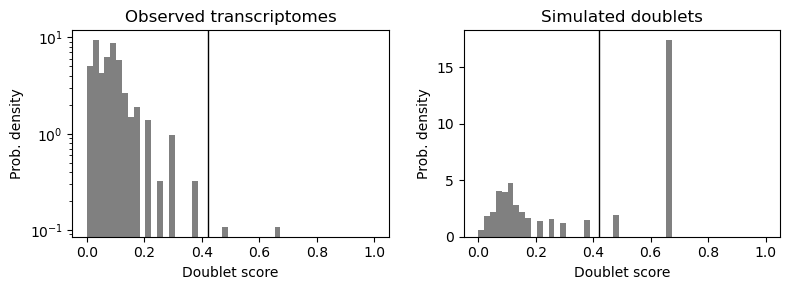

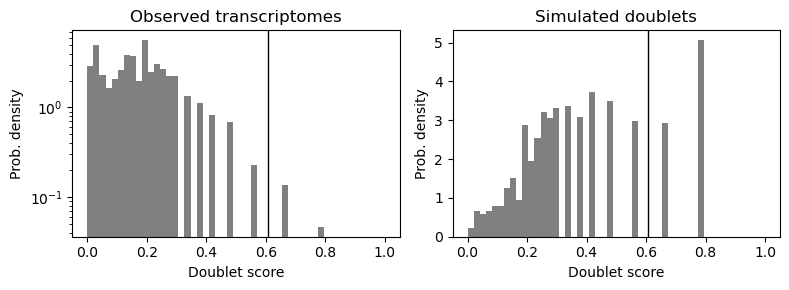

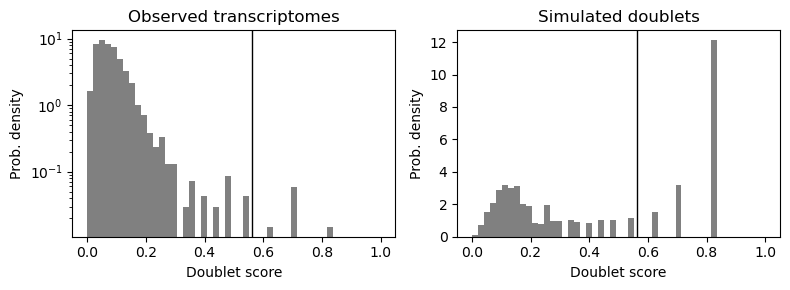

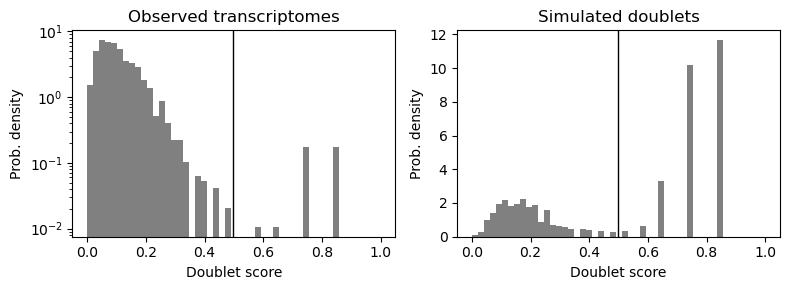

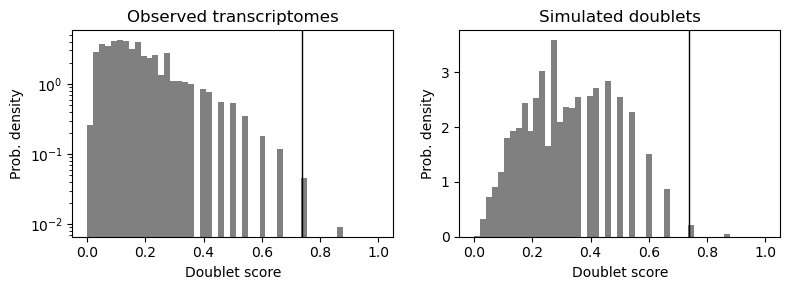

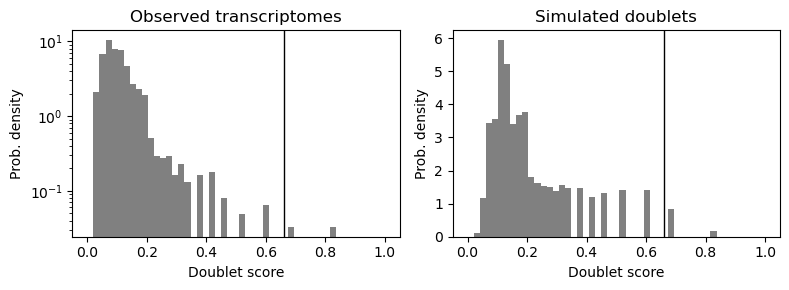

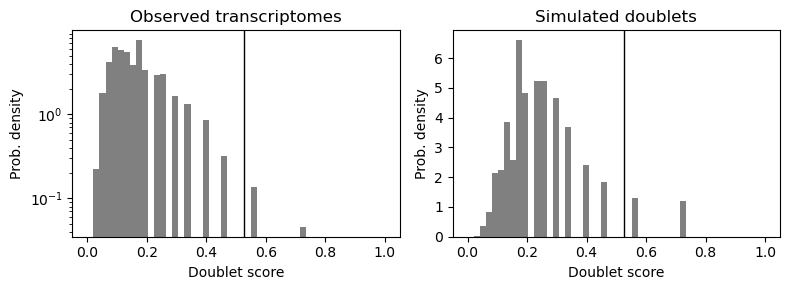

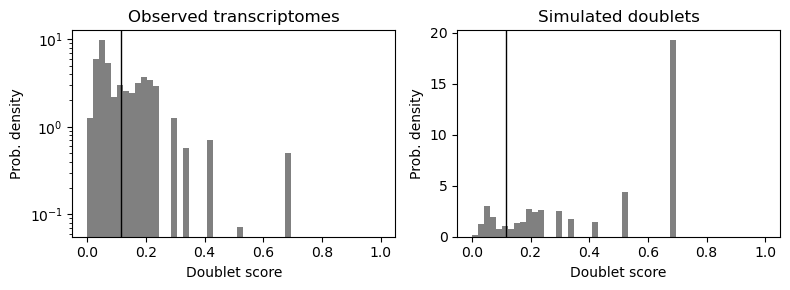

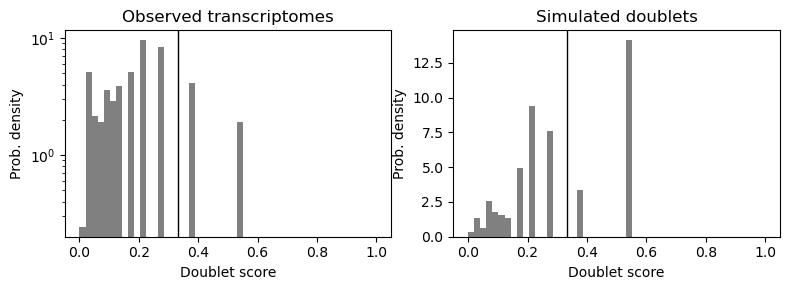

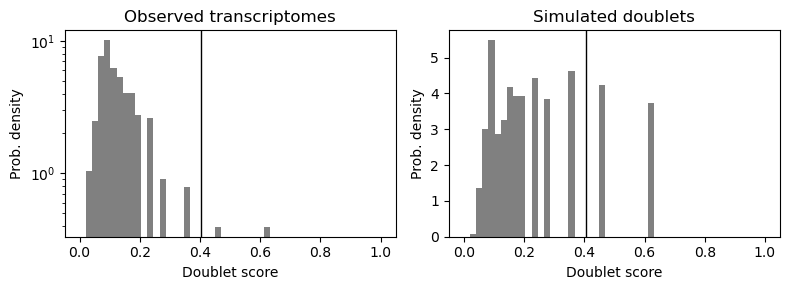

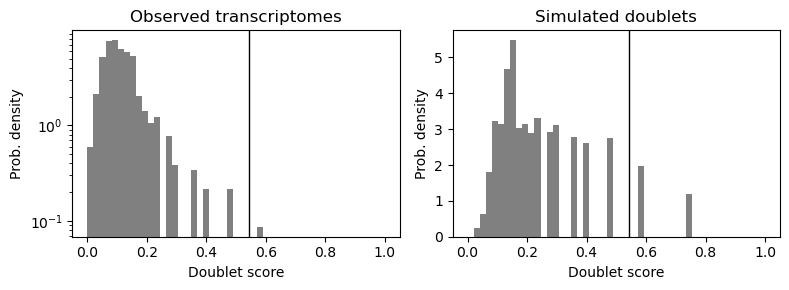

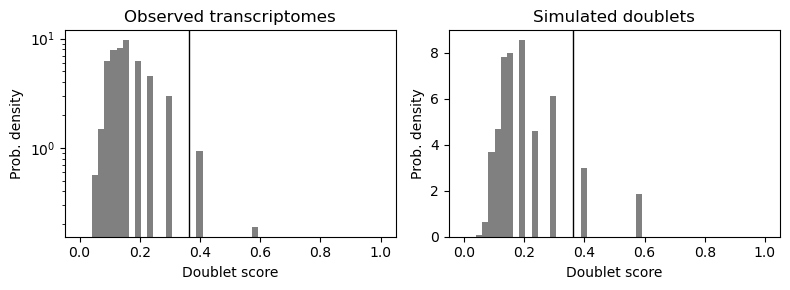

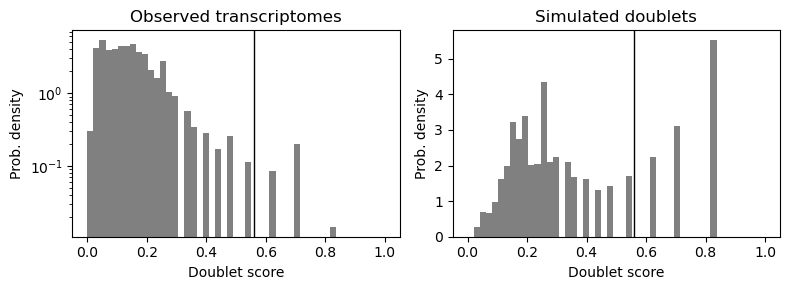

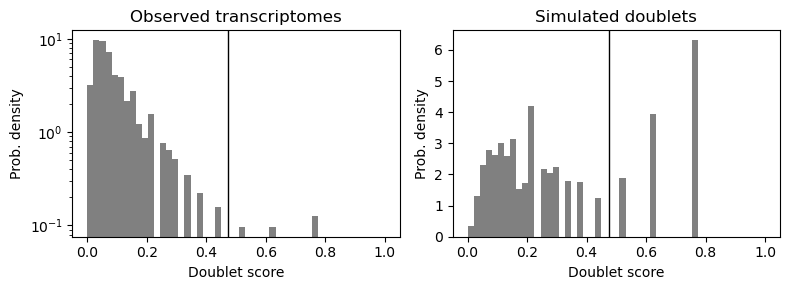

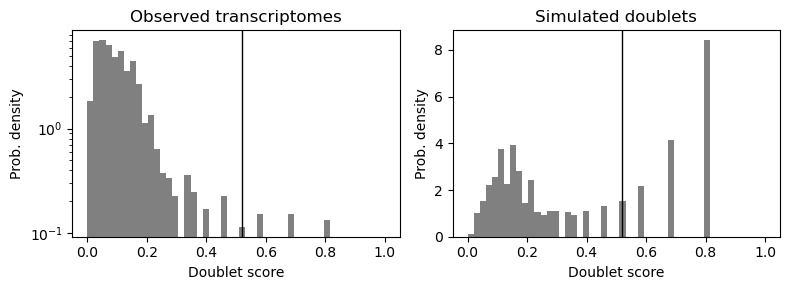

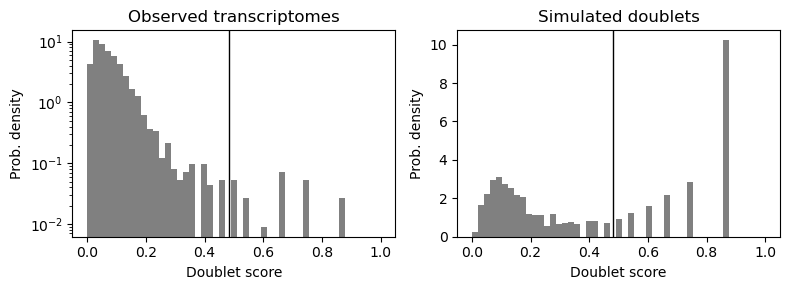

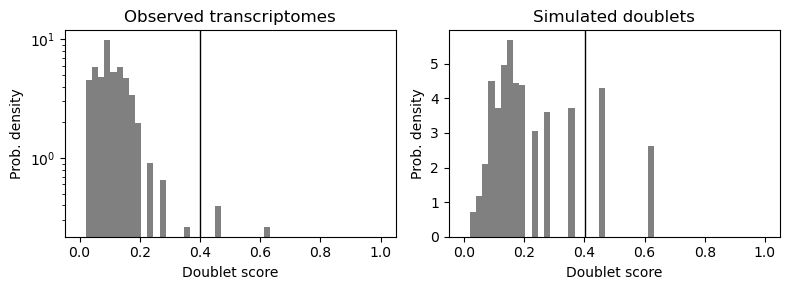

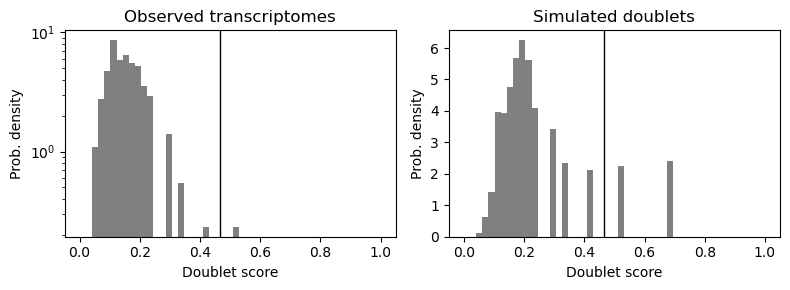

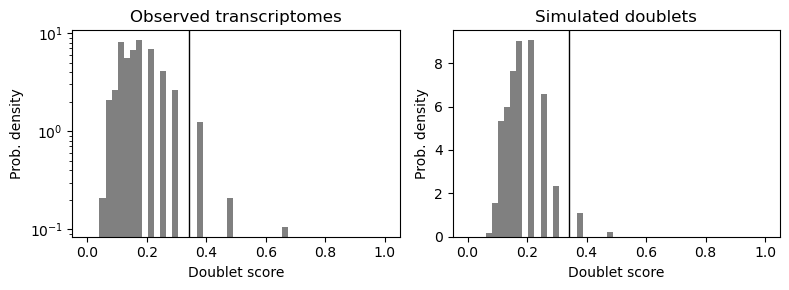

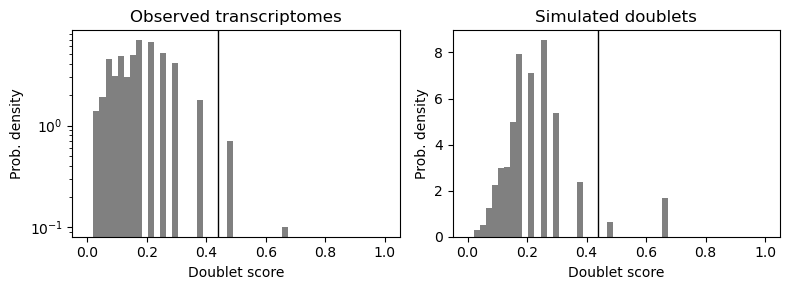

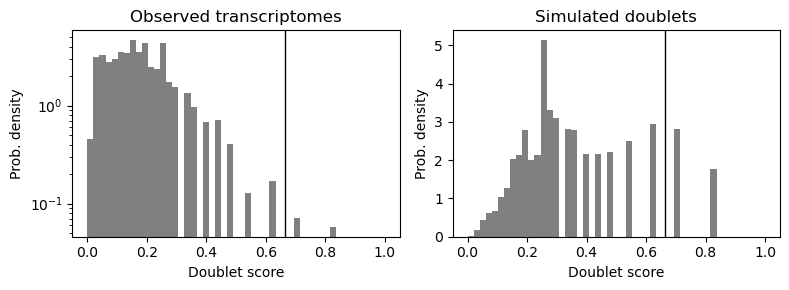

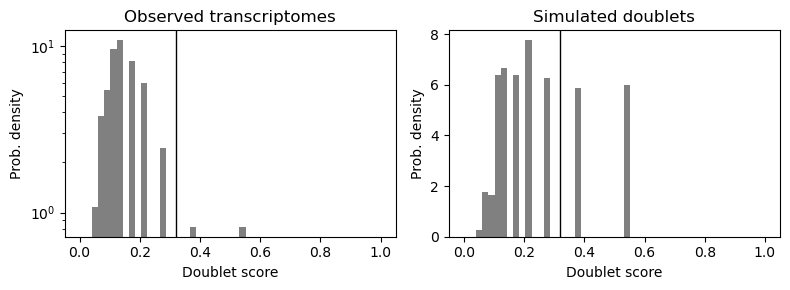

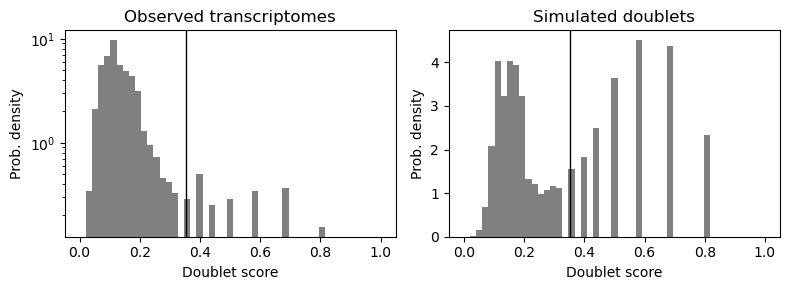

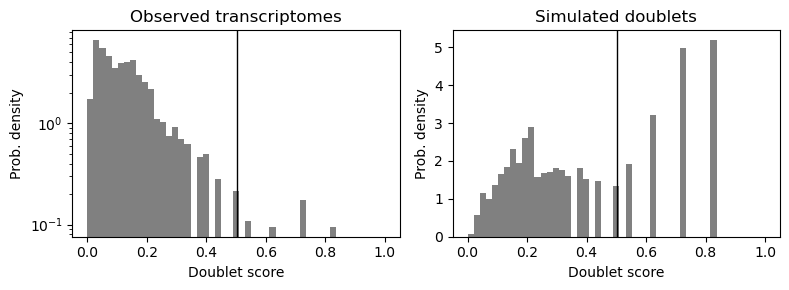

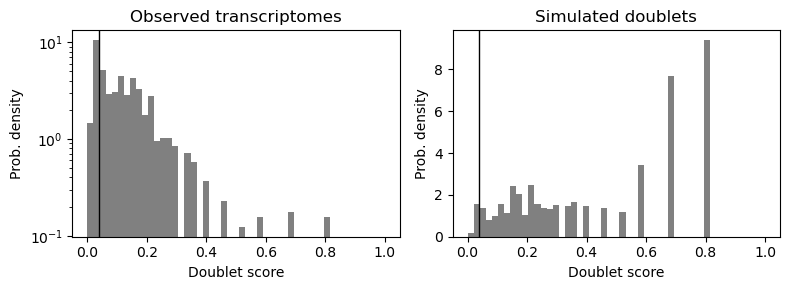

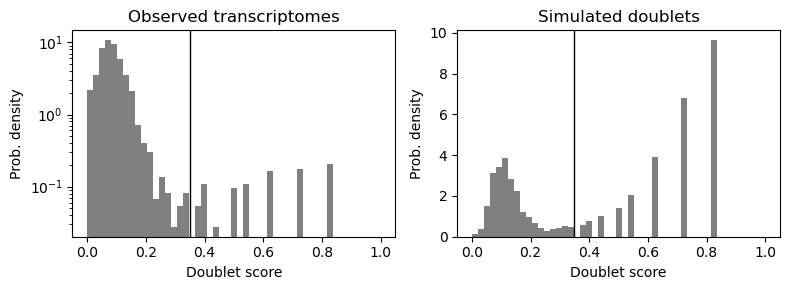

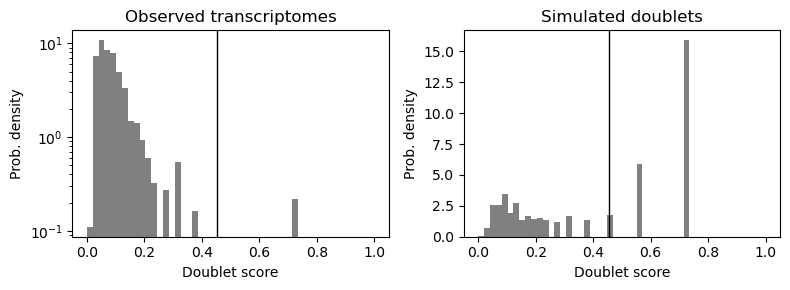

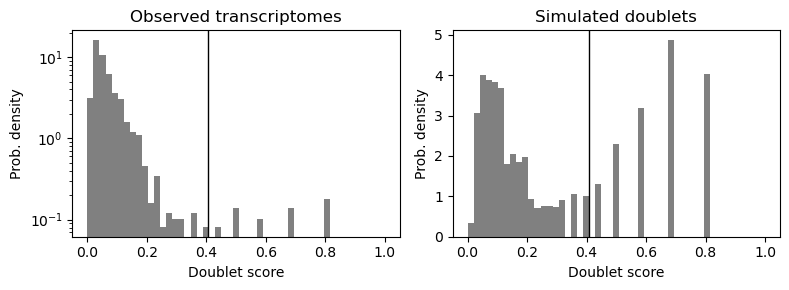

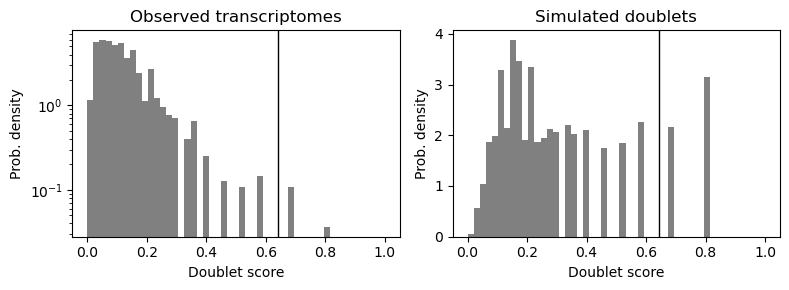

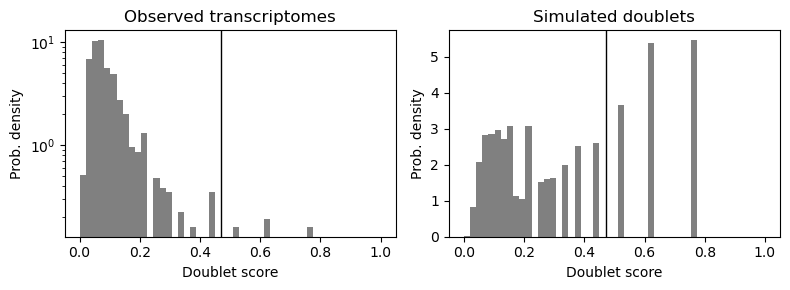

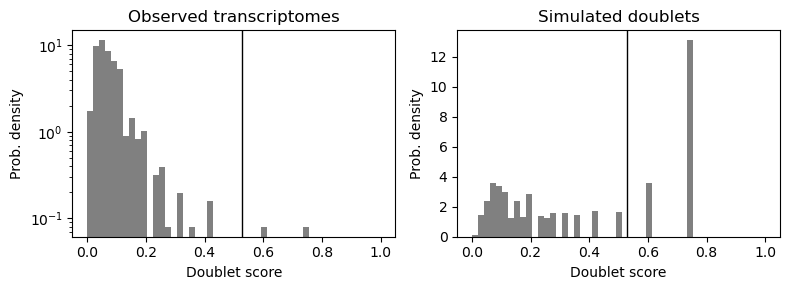

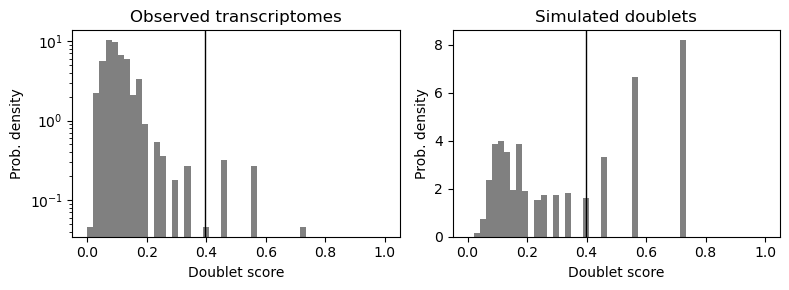

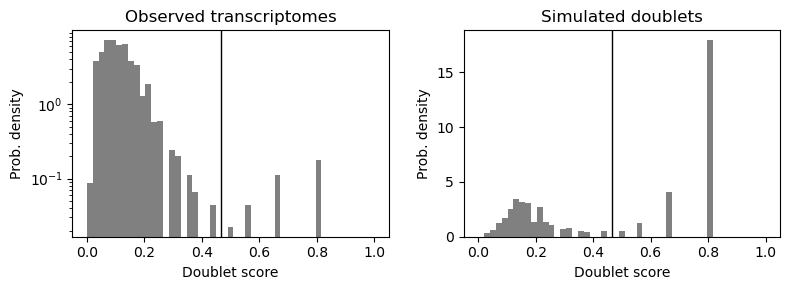

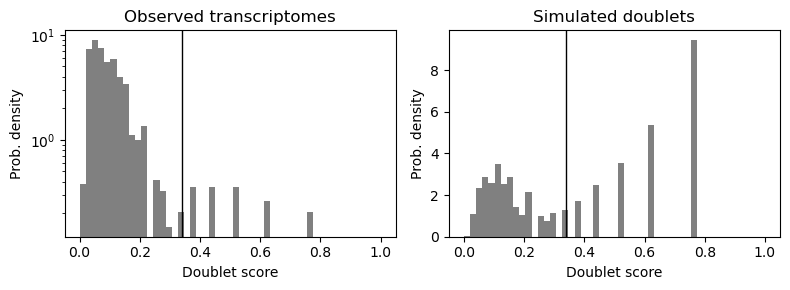

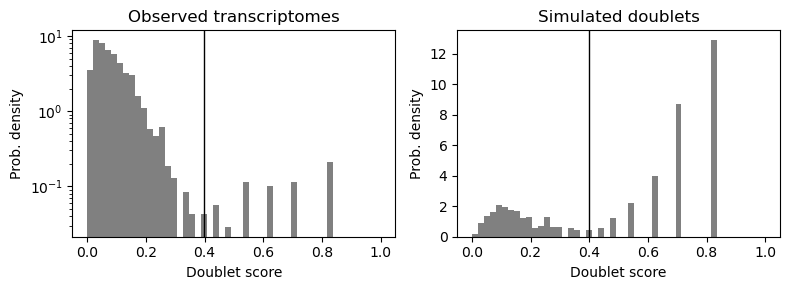

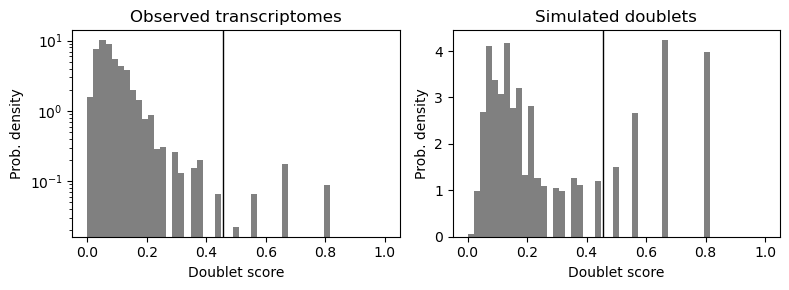

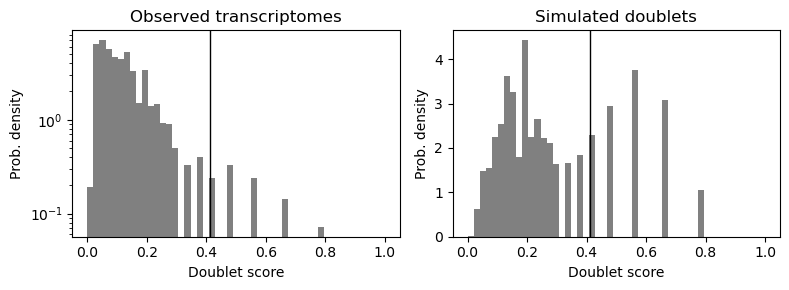

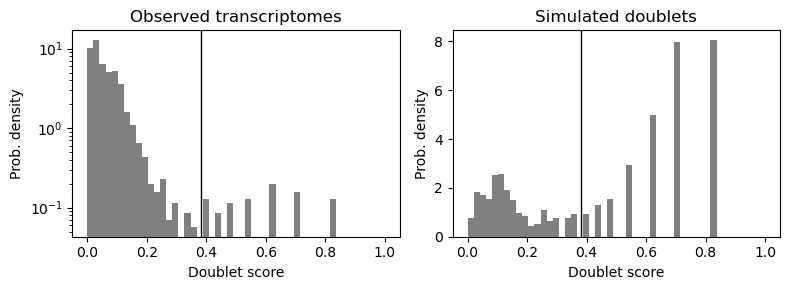

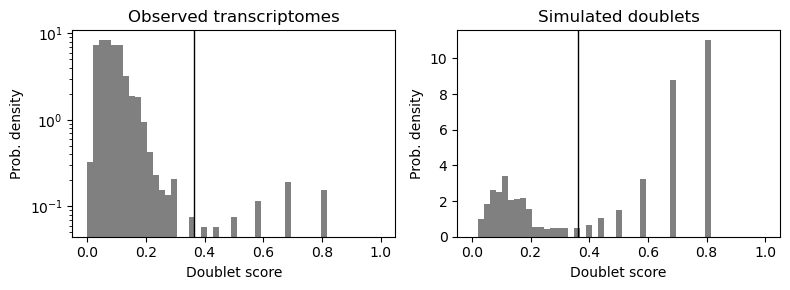

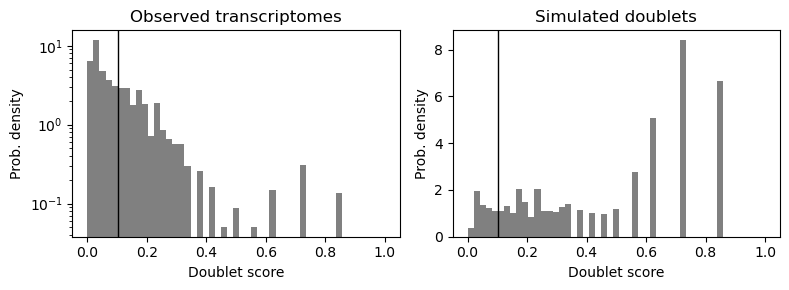

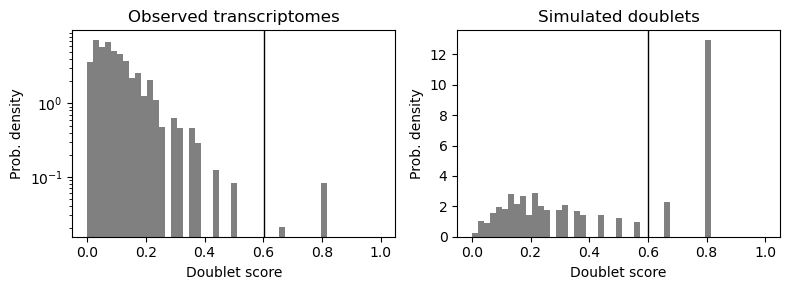

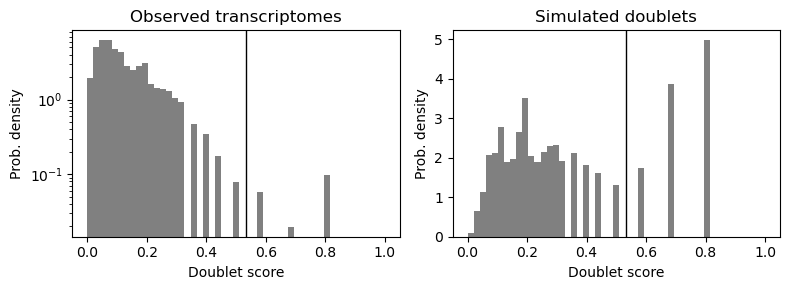

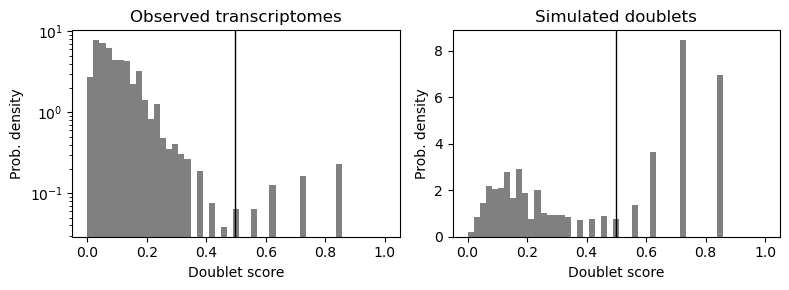

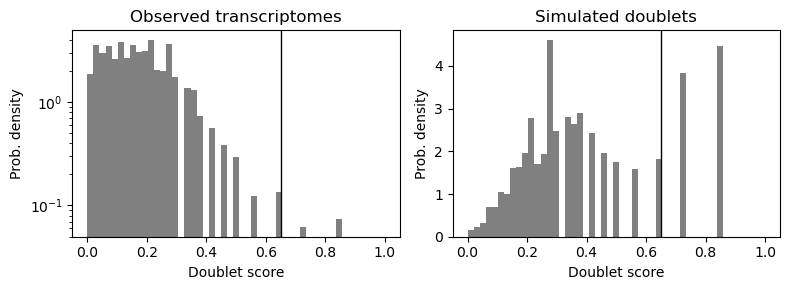

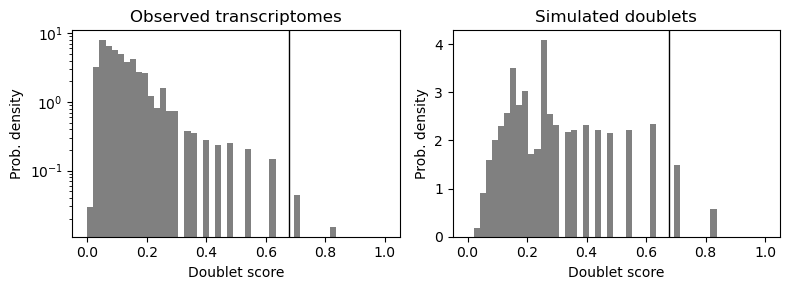

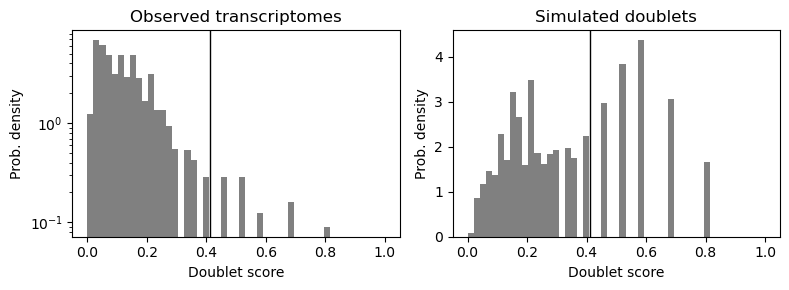

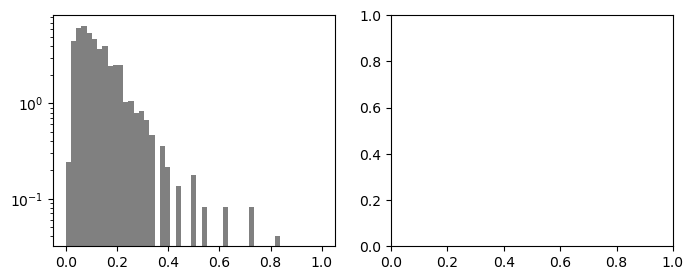

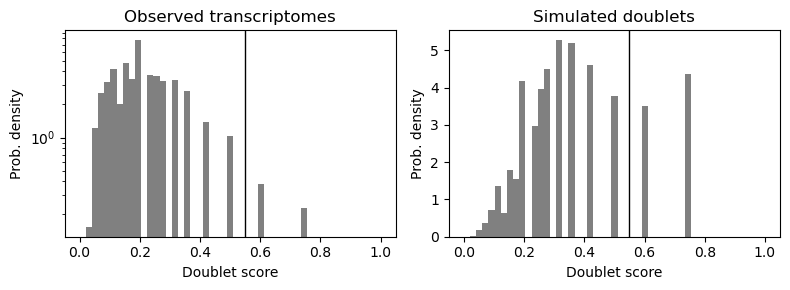

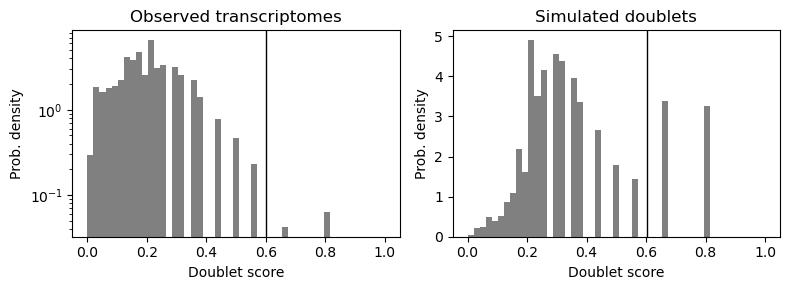

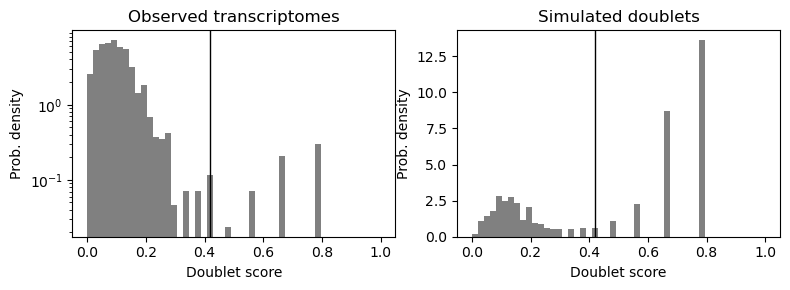

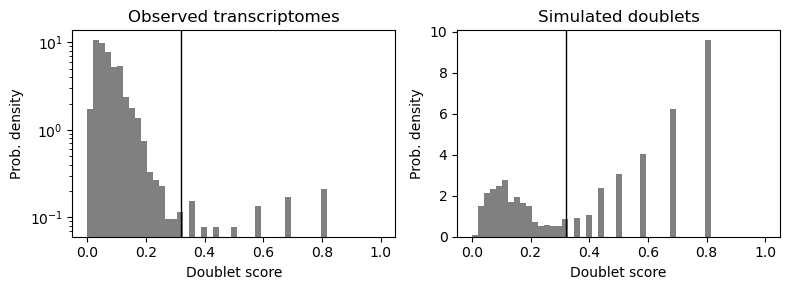

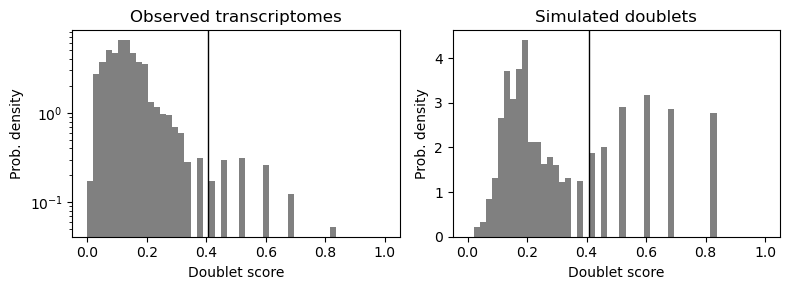

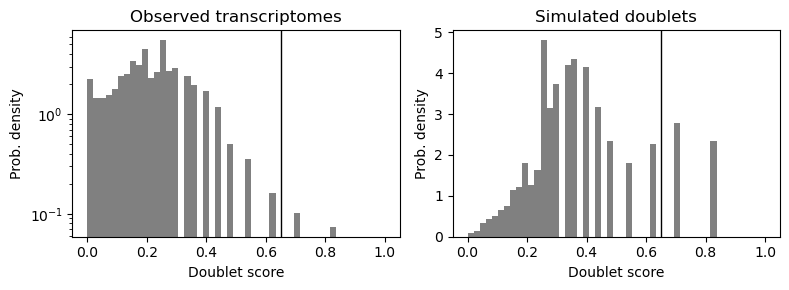

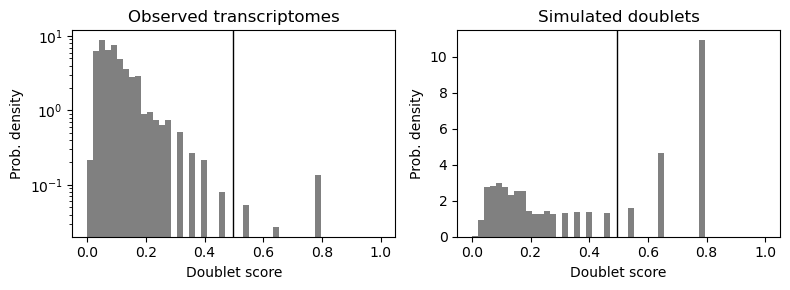

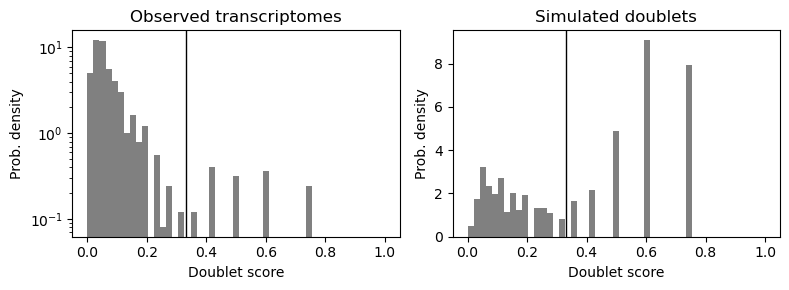

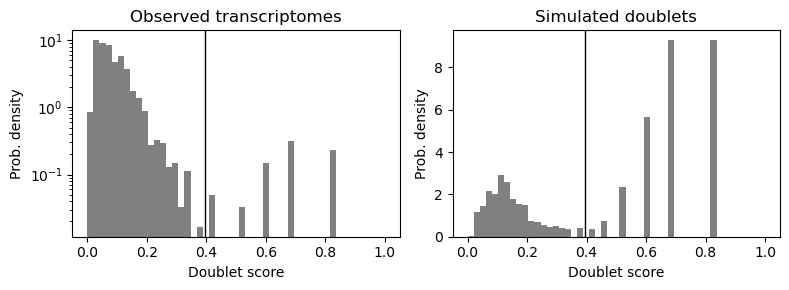

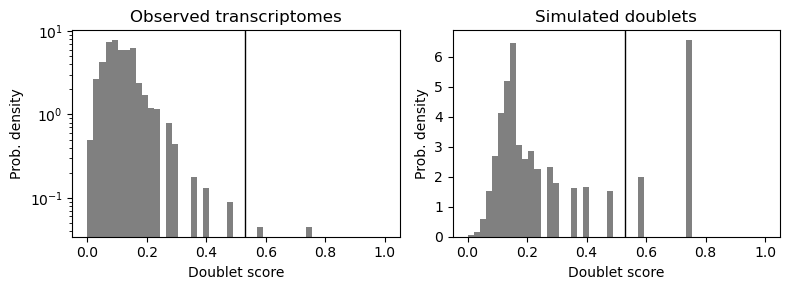

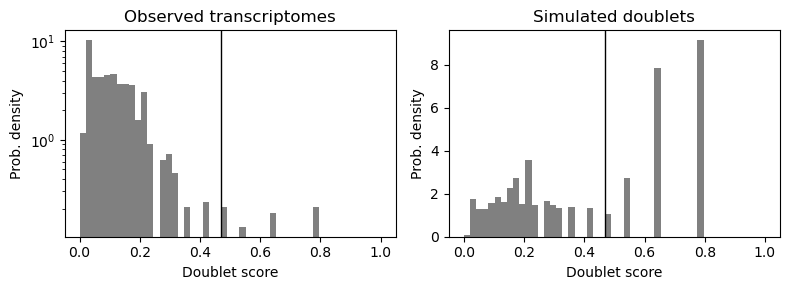

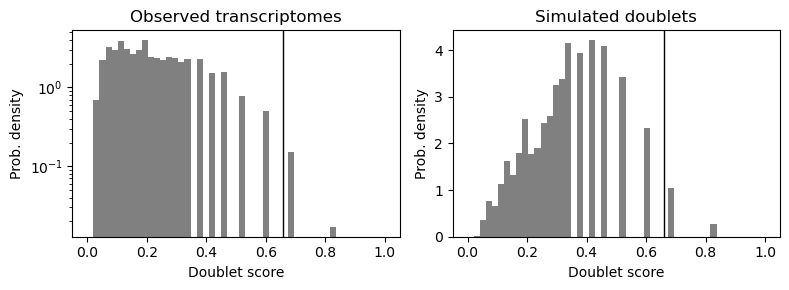

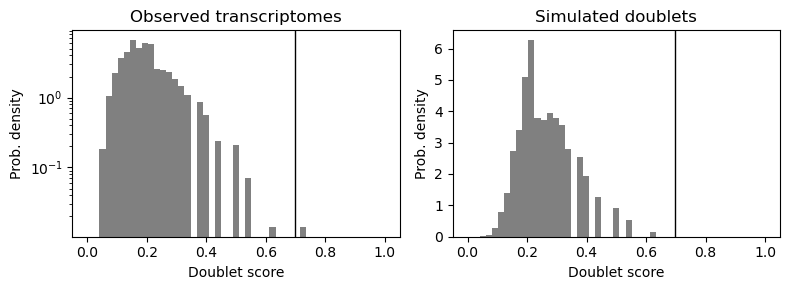

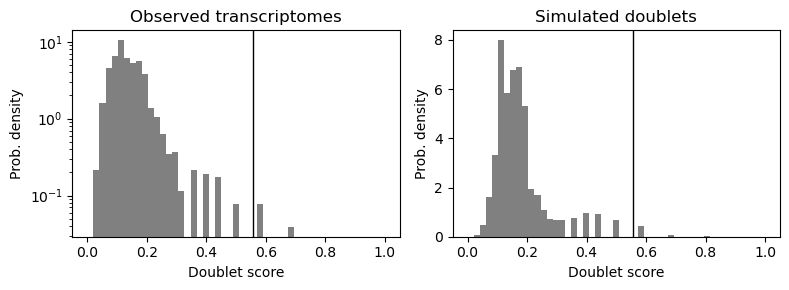

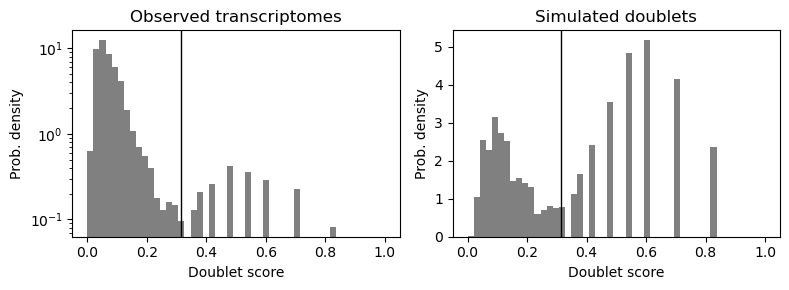

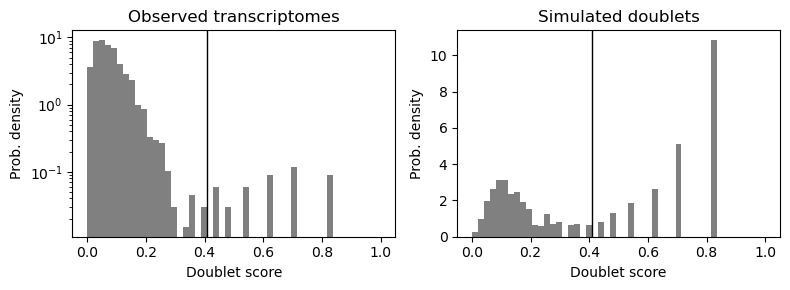

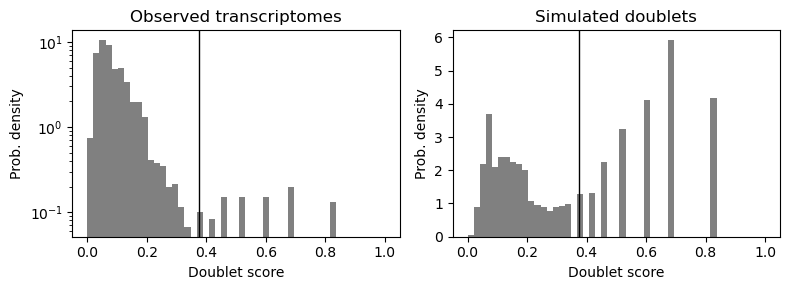

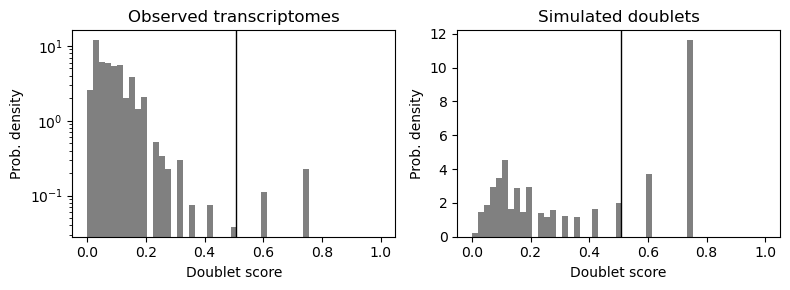

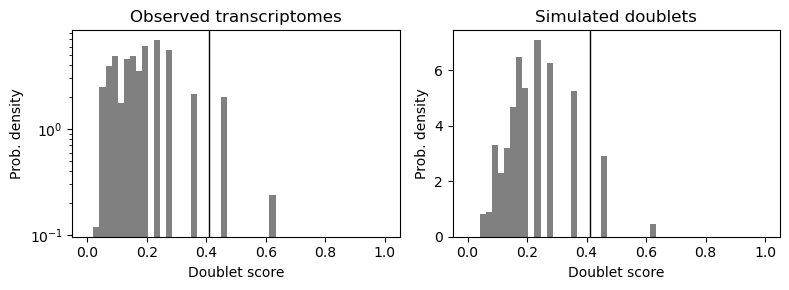

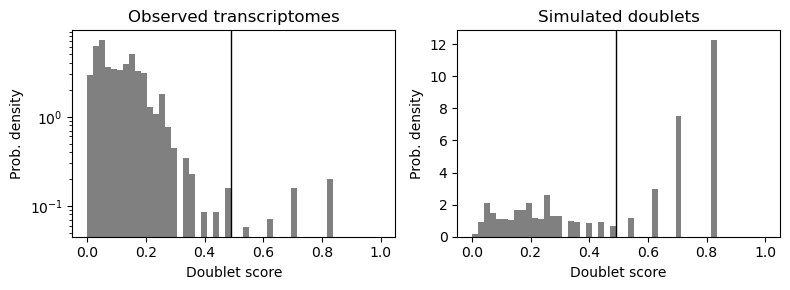

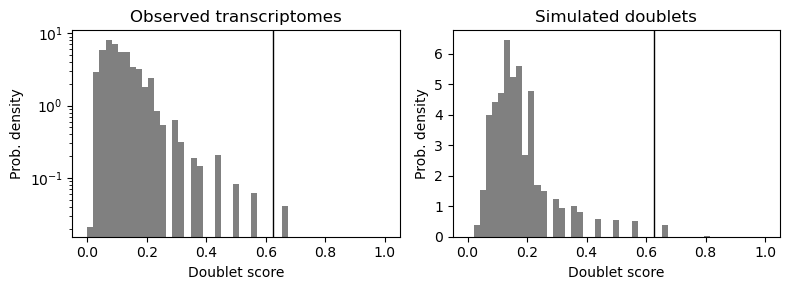

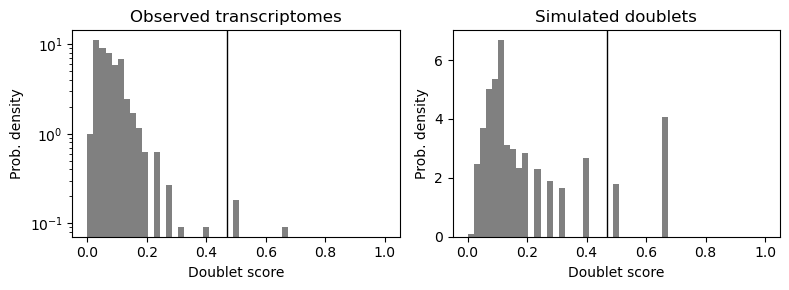

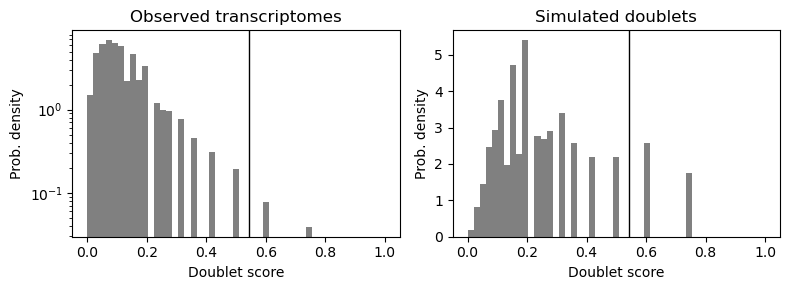

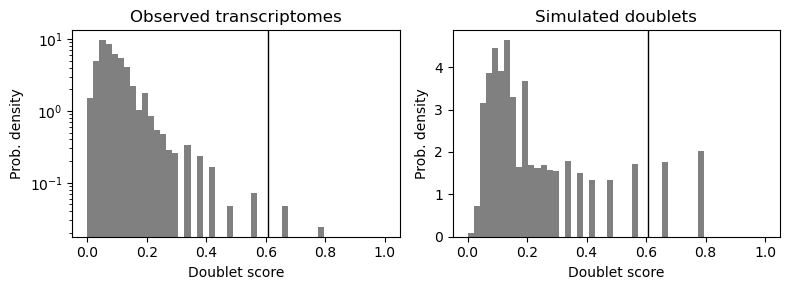

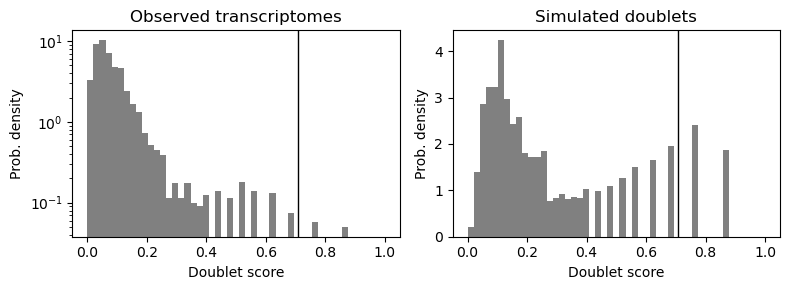

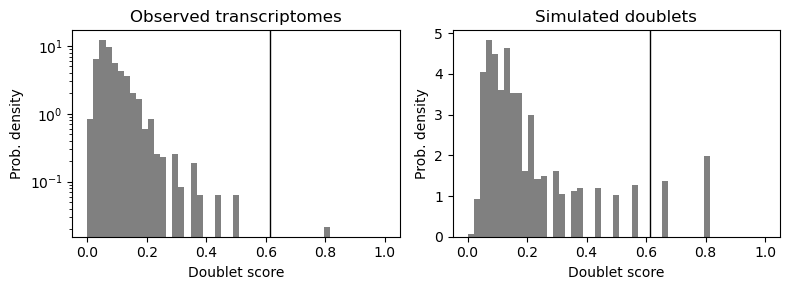

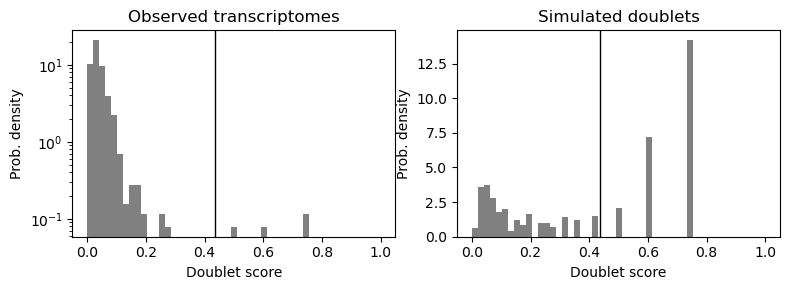

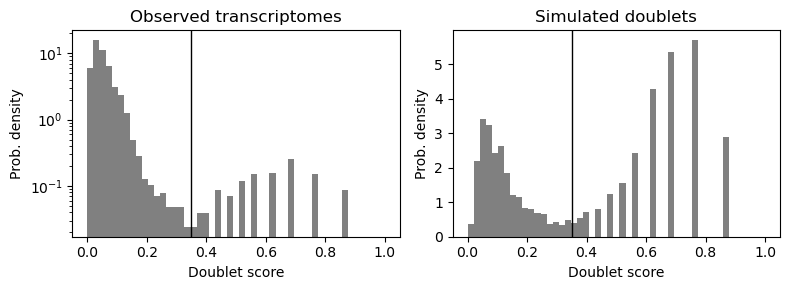

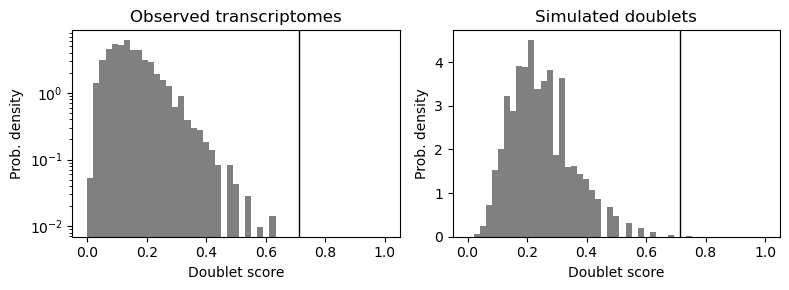

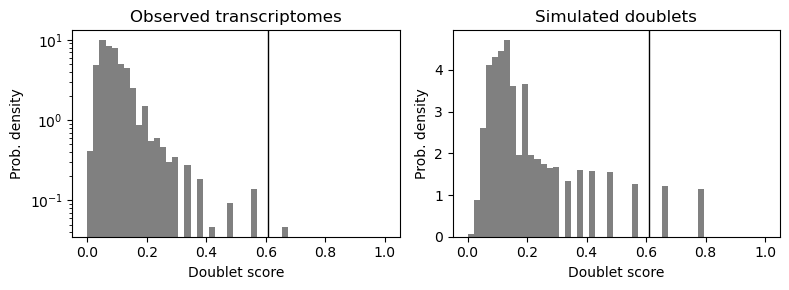

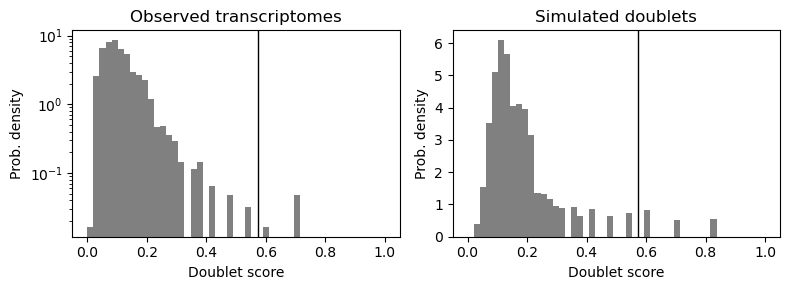

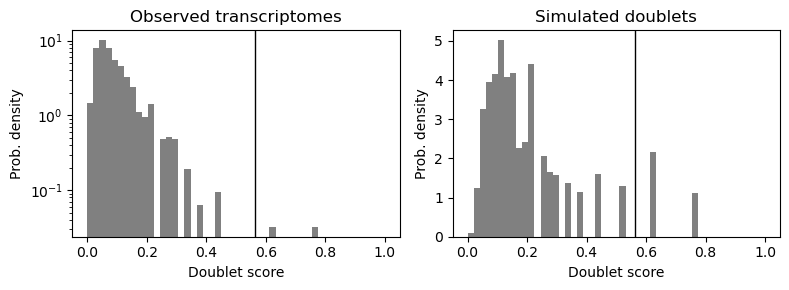

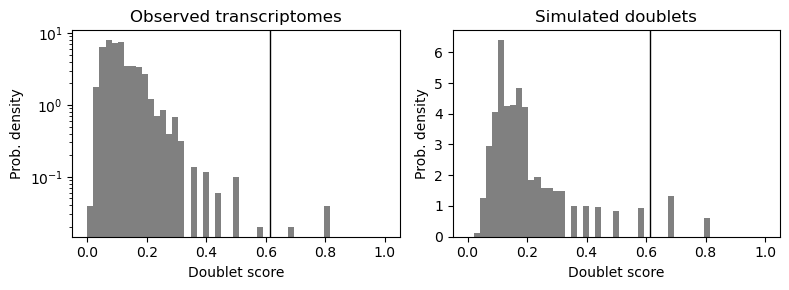

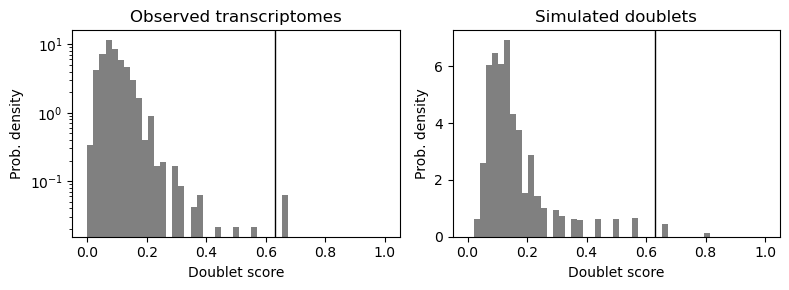

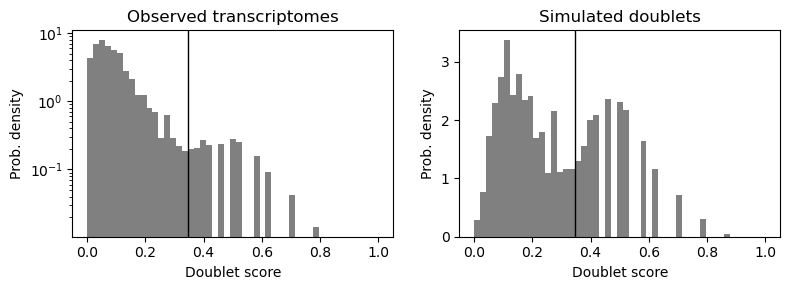

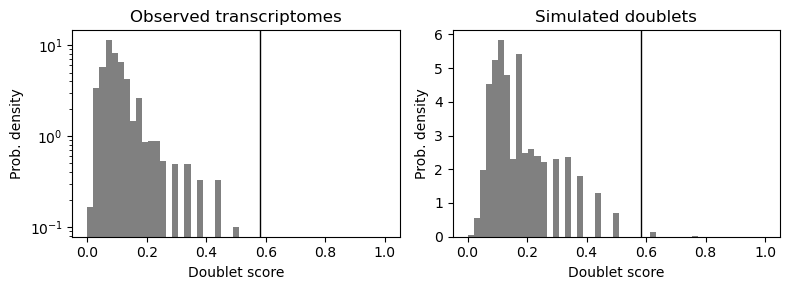

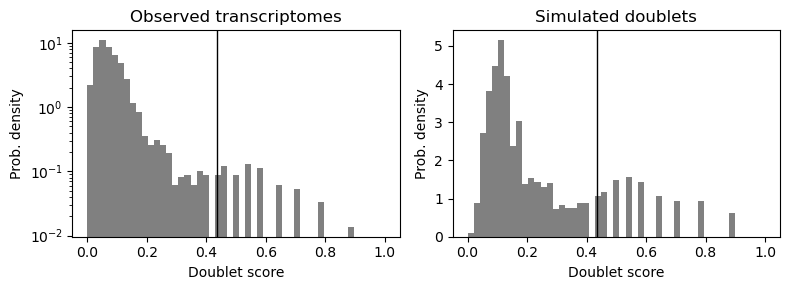

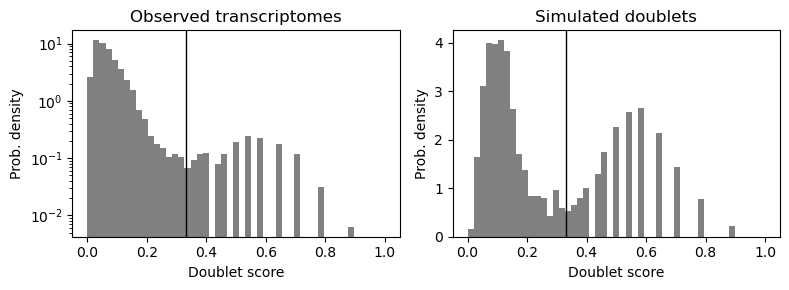

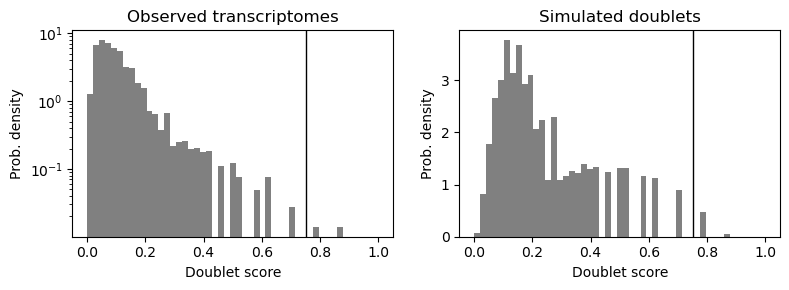

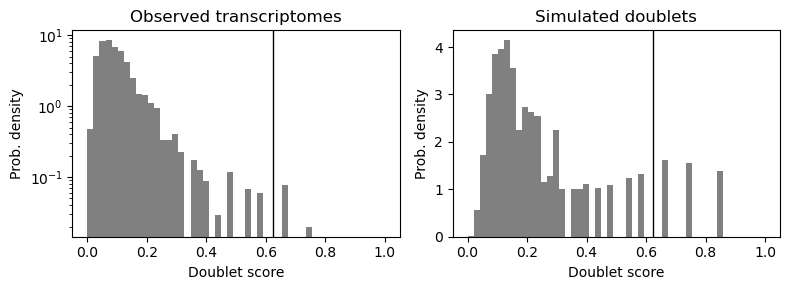

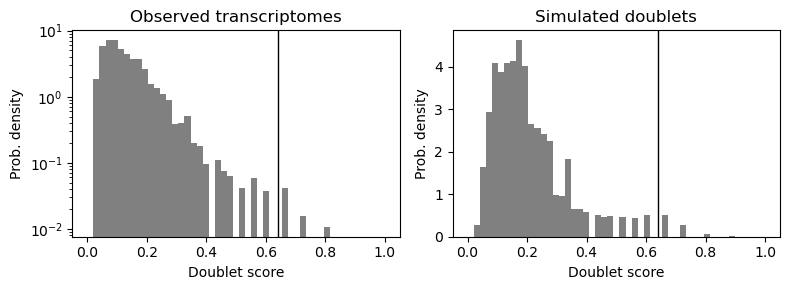

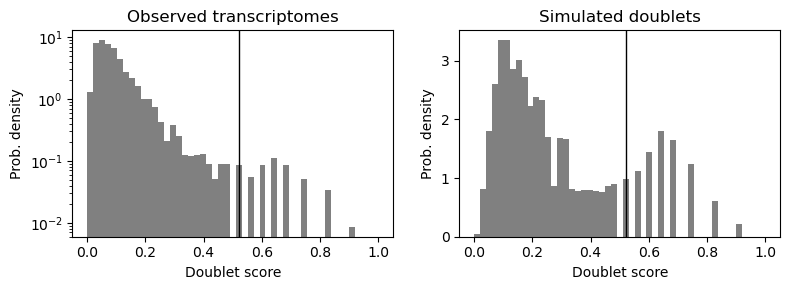

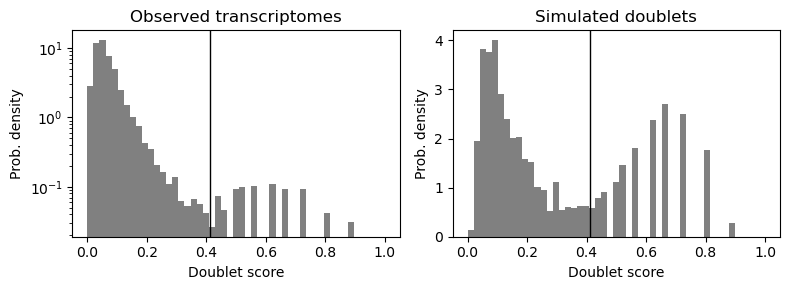

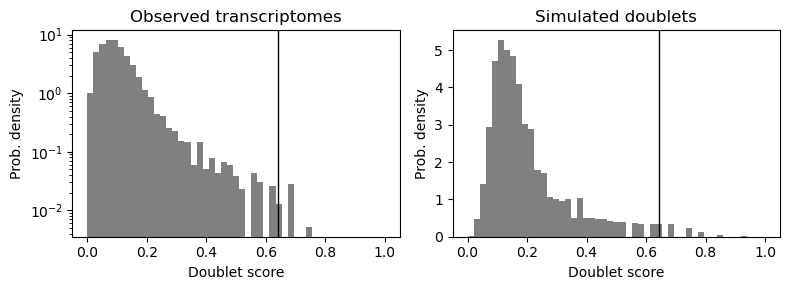

In [13]:
import scrublet as scr
for i, adata in enumerate(adata_list):
    try:
        # Scrublet 객체 생성
        scrub = scr.Scrublet(adata.X)
        
        doublet_scores, predicted_doublets = scrub.scrub_doublets()
        
        adata.obs['doublet_scores'] = doublet_scores
        adata.obs['predicted_doublets'] = predicted_doublets
        
        print(f"Processed adata {i + 1}/{len(adata_list)} successfully.")
        scrub.plot_histogram()
    except Exception as e:
        print(f"Error in processing adata {i + 1}/{len(adata_list)}: {e}")
        # adata.obs의 doublet_scores와 predicted_doublets에 모두 NA를 설정
        adata.obs['doublet_scores'] = pd.Series([np.nan] * adata.shape[0])
        adata.obs['predicted_doublets'] = pd.Series([np.nan] * adata.shape[0])
        continue

del scrub, doublet_scores, predicted_doublets
# 3m 36s for 24 samples
# 2m 47s for 24 samples
# 1m 24.9s for Normalized, log scaled 24 samples

# 4m 48s for 95 samples ~250k cells

In [14]:
# visualize and FILTER the doublets <- 돌려야 함.
for i in range(len(adata_list)):
    # visualize the doublets
    # sc.pp.pca(adata_list[i])
    # sc.pp.neighbors(adata_list[i])
    # sc.tl.umap(adata_list[i])
    # sc.pl.umap(adata_list[i], color=['doublet_scores', 'predicted_doublets'])
    
    # filter the doublets
    try:
        adata_list[i] = adata_list[i][~adata_list[i].obs['predicted_doublets'], :]
    except Exception as e:
        continue
del i

In [15]:
# 세포가 1개 이상인 샘플만 남기기
adata_list = [adata for adata in adata_list if adata.n_obs > 0]
len(adata_list)

94

In [16]:
# 각 adata의 n_obs 값을 확인하고, 그 중 최솟값을 구함
n_obs_list = [adata.n_obs for adata in adata_list]
min_n_obs = min(n_obs_list)

print(f"The minimum n_obs in adata_list is {min_n_obs}.")

The minimum n_obs in adata_list is 153.


# Normalization and log scale the data
> Scrublet으로 doublet 제거하기 전에 하면 Pt23 샘플에서 오류남. 이유는 모르고 predicted_doublet에 None이 저장됨.

In [17]:
for adata in adata_list:
    sc.pp.normalize_total(adata, target_sum = 1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, min_mean = 0.0125, max_mean = 3, min_disp = 0.5)

c:\Users\heung\anaconda3\Lib\site-packages\scanpy\preprocessing\_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
c:\Users\heung\anaconda3\Lib\site-packages\scanpy\preprocessing\_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
c:\Users\heung\anaconda3\Lib\site-packages\scanpy\preprocessing\_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
c:\Users\heung\anaconda3\Lib\site-packages\scanpy\preprocessing\_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
c:\Users\heung\anaconda3\Lib\site-packages\scanpy\preprocessing\_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
c:\Users\heung\anaconda3\Lib\site-packages\scanpy\preprocessing\_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  vi

# Merge the data

In [18]:
adata = sc.concat(adata_list, join = 'outer', label = 'sample', keys = [adata.obs['sample'].unique()[0] for adata in adata_list])
adata.obs.drop(columns=['n_genes_by_counts', 'predicted_doublets', 'doublet_scores'], inplace=True)

adata.obs_names_make_unique()

# filter out genes expressed in less than 3 cells
sc.pp.filter_genes(adata, min_cells=3)

# preserve the raw data
adata.layers['counts'] = adata.X.copy() # scVI use this data

c:\Users\heung\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\heung\anaconda3\Lib\site-packages\anndata\utils.py:260: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['TCAGCAACAAGATGGC-1', 'TCAGTTTCAGGCGTTC-1', 'GGGAGTAGTTGCTTGA-1', 'GTCGAATGTACCTAGT-1']
  warnings.warn(


# Save the merged adata

In [19]:

adata.write_h5ad(folder_path + '\\adata_processed.h5ad')